In [1]:
!pip -q install -U transformers accelerate bitsandbytes datasets seqeval numpy pandas matplotlib scikit-learn json5 tqdm


In [2]:
import os, re, time, random, json, json5
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from dataclasses import dataclass
from datasets import load_dataset
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import normalize
from seqeval.metrics import precision_score, recall_score, f1_score
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device, "|", torch.cuda.get_device_name(0) if device=="cuda" else "cpu")


device: cuda | Tesla T4


In [17]:
DATASET_NAME = "tner/conll2003"
REVISION = "refs/convert/parquet"

TRAIN_POOL = 500
TEST_N = 30

ds = load_dataset(DATASET_NAME, revision=REVISION)

train_raw = ds["train"].shuffle(seed=SEED).select(range(min(TRAIN_POOL, len(ds["train"]))))
test_raw  = ds["test"].shuffle(seed=SEED).select(range(min(TEST_N, len(ds["test"]))))

tag_col = "tags"

CONLL_ID2TAG = {
    0:"O",
    1:"B-PER", 2:"I-PER",
    3:"B-ORG", 4:"I-ORG",
    5:"B-LOC", 6:"I-LOC",
    7:"B-MISC", 8:"I-MISC",
}

def norm_tag_seq(tags):
    out = []
    for t in tags:
        if isinstance(t, (int, np.integer)):
            out.append(CONLL_ID2TAG.get(int(t), "O"))
            continue
        s = str(t).strip().upper()
        m = re.match(r"^(TAG|LABEL)_(\d+)$", s)
        if m:
            out.append(CONLL_ID2TAG.get(int(m.group(2)), "O"))
            continue
        out.append(s if s in CONLL_ID2TAG.values() else "O")
    return out

def to_tokens_tags_fixed(ex):
    toks = ex["tokens"] if "tokens" in ex else ex.get("words", None)
    if toks is None:
        raise RuntimeError("no tokens field")
    tags = norm_tag_seq(ex[tag_col])
    return toks, tags

train_tokens_tags = [to_tokens_tags_fixed(ex) for ex in train_raw]
test_tokens_tags  = [to_tokens_tags_fixed(ex) for ex in test_raw]

print("sample tags:", test_tokens_tags[0][1][:20])
print("unique tags:", sorted({t for _,ts in train_tokens_tags for t in ts}))


sample tags: ['B-PER', 'O', 'B-PER', 'O']
unique tags: ['B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']


In [19]:
def compute_label_stats(train_data, k=2):
    cnt = {}
    for tokens, tags in train_data:
        n = len(tokens)
        ent_idx = set(i for i,tg in enumerate(tags) if tg != "O")
        spans = []
        i = 0
        while i < n:
            tg = tags[i]
            if tg.startswith("B-"):
                j = i + 1
                while j < n and tags[j].startswith("I-"):
                    j += 1
                spans.append((i, j))
                i = j
            else:
                i += 1
        ctx_idx = set()
        for a,b in spans:
            for j in range(max(0, a-k), a):
                if j not in ent_idx:
                    ctx_idx.add(j)
            for j in range(b, min(n, b+k)):
                if j not in ent_idx:
                    ctx_idx.add(j)
        oth_idx = set(range(n)) - ent_idx - ctx_idx
        for i in ent_idx:
            t = tokens[i].lower()
            cnt.setdefault(t, [0,0,0])[0] += 1
        for i in ctx_idx:
            t = tokens[i].lower()
            cnt.setdefault(t, [0,0,0])[1] += 1
        for i in oth_idx:
            t = tokens[i].lower()
            cnt.setdefault(t, [0,0,0])[2] += 1
    stats = {}
    for t,(ce,cc,co) in cnt.items():
        tot = ce+cc+co
        if tot:
            stats[t] = (ce/tot, cc/tot, co/tot)
    return stats

stats = compute_label_stats(train_tokens_tags, k=CTX_K)

WE, WC, WO = 1.0, 1.0, 0.01
def W(tok):
    t = tok.lower()
    if t in stats:
        pe, pc, po = stats[t]
        return WE*pe + WC*pc + WO*po
    return 1.0

HASH_DIM = 4096
hasher = FeatureHasher(n_features=HASH_DIM, input_type="dict", alternate_sign=False)

def sent_dict(tokens, weighted):
    d = {}
    for tok in tokens:
        key = tok.lower()
        d[key] = d.get(key, 0.0) + (W(tok) if weighted else 1.0)
    return d

train_sets = [set(t.lower() for t in toks) for toks,_ in train_tokens_tags]

Xtr_unw = normalize(hasher.transform([sent_dict(toks, False) for toks,_ in train_tokens_tags]), norm="l2", axis=1, copy=True)
Xtr_w   = normalize(hasher.transform([sent_dict(toks, True)  for toks,_ in train_tokens_tags]), norm="l2", axis=1, copy=True)
Xte_unw = normalize(hasher.transform([sent_dict(toks, False) for toks,_ in test_tokens_tags ]), norm="l2", axis=1, copy=True)
Xte_w   = normalize(hasher.transform([sent_dict(toks, True)  for toks,_ in test_tokens_tags ]), norm="l2", axis=1, copy=True)

LAMBDA1, LAMBDA2 = 1.0, 1.0

def retrieve(method, q_idx, k):
    if k <= 0:
        return []
    if method == "random":
        return random.sample(range(len(train_tokens_tags)), k)
    if method == "embed":
        sims = (Xtr_unw @ Xte_unw[q_idx].T).toarray().reshape(-1)
        top = np.argpartition(-sims, kth=min(k, len(sims)-1))[:k]
        top = top[np.argsort(-sims[top])]
        return top.tolist()
    if method == "deer":
        q_tokens, _ = test_tokens_tags[q_idx]
        q_unique = list(dict.fromkeys([t.lower() for t in q_tokens]))
        wsum = np.zeros(len(train_tokens_tags), dtype=np.float32)
        for i,sset in enumerate(train_sets):
            sc = 0.0
            for t in q_unique:
                if t in sset:
                    sc += W(t)
            wsum[i] = sc
        sims = (Xtr_w @ Xte_w[q_idx].T).toarray().reshape(-1)
        score = LAMBDA1*wsum + LAMBDA2*sims
        top = np.argpartition(-score, kth=min(k, len(score)-1))[:k]
        top = top[np.argsort(-score[top])]
        return top.tolist()
    raise ValueError(method)


In [20]:
MODEL_CANDIDATES = [
    "Qwen/Qwen2.5-0.5B-Instruct",
]

bnb = None
if device == "cuda":
    bnb = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_use_double_quant=True,
        bnb_4bit_compute_dtype=torch.float16,
    )

tokenizer = None
model = None
MODEL_NAME = None

for name in MODEL_CANDIDATES:
    try:
        tokenizer = AutoTokenizer.from_pretrained(name, use_fast=True)
        model = AutoModelForCausalLM.from_pretrained(
            name,
            device_map="auto" if device=="cuda" else None,
            quantization_config=bnb if device=="cuda" else None,
            torch_dtype=torch.float16 if device=="cuda" else None,
        )
        MODEL_NAME = name
        break
    except Exception as e:
        print("fail:", name, "|", str(e)[:200])

if tokenizer is None or model is None:
    raise RuntimeError("model load failed")

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model.eval()
print("model:", MODEL_NAME)


model: Qwen/Qwen2.5-0.5B-Instruct


In [21]:
@dataclass
class GenCfg:
    max_new_tokens: int = 64

gen_cfg = GenCfg(max_new_tokens=64)

def safe_json_extract(s):
    if not isinstance(s, str):
        return None
    a = s.find("{"); b = s.rfind("}")
    if a == -1 or b == -1 or b <= a:
        return None
    chunk = s[a:b+1].replace("\u201c", '"').replace("\u201d", '"').replace("\u2019", "'")
    try:
        return json5.loads(chunk)
    except Exception:
        try:
            return json.loads(chunk)
        except Exception:
            return None

def build_demo(tokens, tags):
    return "Tokens: " + " ".join(tokens) + "\nTags: " + " ".join(tags) + "\n"

def build_prompt(demo_indices, query_tokens):
    header = (
        "NER with BIO tags.\n"
        "Valid tags: O, B-PER, I-PER, B-LOC, I-LOC, B-ORG, I-ORG, B-MISC, I-MISC.\n"
        "Return ONLY JSON: {\"tags\": [\"...\", ...]} with same length as Tokens.\n\n"
    )
    demos = ""
    for idx in demo_indices:
        toks, tags = train_tokens_tags[idx]
        demos += build_demo(toks, tags) + "\n"
    q = "Tokens: " + " ".join(query_tokens) + "\nJSON:"
    user = header + demos + q
    if hasattr(tokenizer, "apply_chat_template"):
        msgs = [{"role":"system","content":"You follow format strictly."},{"role":"user","content":user}]
        return tokenizer.apply_chat_template(msgs, tokenize=False, add_generation_prompt=True)
    return user

VALID = {"O","B-PER","I-PER","B-LOC","I-LOC","B-ORG","I-ORG","B-MISC","I-MISC"}

def decode_tags(resp, n):
    obj = safe_json_extract(resp)
    tags = None
    if isinstance(obj, dict) and isinstance(obj.get("tags", None), list):
        tags = [str(x).upper().strip() for x in obj["tags"]]
    if tags is None:
        tags = []
    tags = [t if t in VALID else "O" for t in tags]
    if len(tags) < n:
        tags += ["O"] * (n - len(tags))
    return tags[:n]

def generate_tags(demo_indices, query_tokens):
    prompt = build_prompt(demo_indices, query_tokens)
    enc = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=4096).to(model.device)
    in_len = enc["input_ids"].shape[1]
    with torch.no_grad():
        out = model.generate(
            **enc,
            do_sample=False,
            num_beams=1,
            max_new_tokens=gen_cfg.max_new_tokens,
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )
    gen_ids = out[0][in_len:]
    resp = tokenizer.decode(gen_ids, skip_special_tokens=True)
    return decode_tags(resp, len(query_tokens)), resp[:200]


In [22]:
def run_eval(method, k):
    y_true, y_pred = [], []
    times = []
    for qi,(toks,tags) in enumerate(tqdm(test_tokens_tags, desc=f"{method} k={k}", leave=False)):
        demo_idx = retrieve(method, qi, k) if k>0 else []
        t0 = time.time()
        pred, _ = generate_tags(demo_idx, toks)
        times.append(time.time() - t0)
        y_true.append(tags)
        y_pred.append(pred)
    p = precision_score(y_true, y_pred)
    r = recall_score(y_true, y_pred)
    f = f1_score(y_true, y_pred)
    return p, r, f, float(np.mean(times))

methods = ["random", "embed", "deer"]
rows = []
for k in [0,1,4]:
    for m in methods:
        p,r,f,ts = run_eval(m, k)
        rows.append({"method": m, "k": k, "precision": p, "recall": r, "f1": f, "sec_per_sent": ts})

df = pd.DataFrame(rows).sort_values(["k","method"]).reset_index(drop=True)
display(df)
df.to_csv("/content/deer_ner_results.csv", index=False)
print("/content/deer_ner_results.csv")


random k=0:   0%|          | 0/30 [00:00<?, ?it/s]

embed k=0:   0%|          | 0/30 [00:00<?, ?it/s]

deer k=0:   0%|          | 0/30 [00:00<?, ?it/s]

random k=1:   0%|          | 0/30 [00:00<?, ?it/s]

embed k=1:   0%|          | 0/30 [00:00<?, ?it/s]

deer k=1:   0%|          | 0/30 [00:00<?, ?it/s]

random k=4:   0%|          | 0/30 [00:00<?, ?it/s]

embed k=4:   0%|          | 0/30 [00:00<?, ?it/s]

deer k=4:   0%|          | 0/30 [00:00<?, ?it/s]

,method,k,precision,recall,f1,sec_per_sent
0,deer,0,0.027778,0.027027,0.027397,2.308787
1,embed,0,0.027778,0.027027,0.027397,2.319234
2,random,0,0.027778,0.027027,0.027397,2.315528
3,deer,1,0.104167,0.067568,0.081967,2.299214
4,embed,1,0.134615,0.094595,0.111111,1.779393
5,random,1,0.093750,0.040541,0.056604,1.943668
6,deer,4,0.160000,0.108108,0.129032,2.242115
7,embed,4,0.150000,0.121622,0.134328,2.137279
8,random,4,0.070175,0.054054,0.061069,1.917688


/content/deer_ner_results.csv


f1_vs_k.png


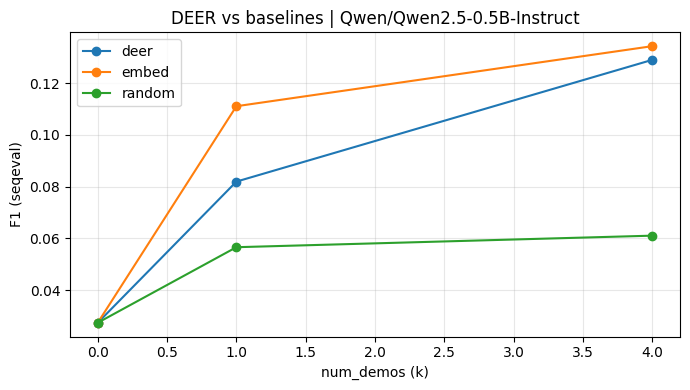

In [25]:
pivot = df.pivot_table(index="k", columns="method", values="f1").loc[[0, 1, 4]]

plt.figure(figsize=(7,4))
for col in pivot.columns:
    plt.plot(pivot.index.tolist(), pivot[col].tolist(), marker="o", label=col)
plt.xlabel("num_demos (k)")
plt.ylabel("F1 (seqeval)")
plt.title(f"DEER vs baselines | {MODEL_NAME}")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("f1_vs_k.png", dpi=200, bbox_inches="tight")
print("f1_vs_k.png")
plt.show()


ICL работает: при k=0 все плохо Как только добавляем демонстрации, качество растёт: при k=1 лучший результат даёт embed, а DEER тоже заметно улучшает базу , при этом random хуже. На k=4 качество ещё повышается, у embed (F1 = 0.134), но DEER уже практически рядом (F1 = 0.129) и оба уверенно лучше random (F1 ≈ 0.061).

По скорости разброс небольшой


Итог: DEER показал себя “хорошо” в сравнении с random и zero-shot, подтверждая идею статьи, что guided retrieval и примеры важны